# Ray

[Ray](https://docs.ray.io/en/master/index.html) is a unified framework for scaling AI and Python applications. In this notebook, we'll walk through how to set up a Ray cluster in CML.

## Set up a Ray cluster

A Ray cluster is a set of worker nodes connected to a common Ray head node. Each node runs Ray helper processes to facilitate distributed scheduling and memory management. The head node runs additional control processes (highlighted in blue)"

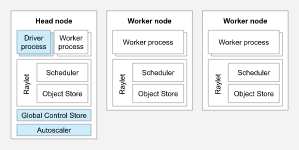

In this example we will create this infrastructure in CML via the [Workers API](https://docs.cloudera.com/machine-learning/cloud/distributed-computing/topics/ml-workers-api.html) and connect to it from this CML Session. 

In [1]:
# %pip install ray[default]

In [1]:
import os
import cdsw
import ray

## Start Ray head node

Every Ray cluster has one node which is designated as the head node of the cluster. The head node is identical to other worker nodes, except that it also runs singleton processes responsible for cluster management such as the autoscaler and the Ray driver processes which run Ray jobs. Ray may schedule tasks and actors on the head node just like any other worker node, unless configured otherwise.


In [2]:
DASHBOARD_PORT = os.environ['CDSW_APP_PORT']

# We need to start the ray process with --block else the command completes and the CML Worker terminates
head_start_cmd = f"!ray start --head --block --include-dashboard=true --dashboard-port={DASHBOARD_PORT}"
ray_head = cdsw.launch_workers(
    n=1,
    cpu=2,
    memory=4,
    code=head_start_cmd,
)

ray_head_details = cdsw.await_workers(
  ray_head, 
  wait_for_completion=False, 
  timeout_seconds=90
)

Once we have the ray head node running we need to get its IP address that the worker nodes need to join the cluster. 

In [3]:
ray_head_ip = ray_head_details['workers'][0]['ip_address']
ray_head_addr = ray_head_ip + ':6379'
ray_head_addr

'100.100.233.153:6379'

## Start Ray worker nodes

Worker nodes do not run any head node management processes, and serve only to run user code in Ray tasks and actors. They participate in distributed scheduling, as well as the storage and distribution of Ray objects in cluster memory.



In [4]:
# Creating 2 workers in addition to the Head Node
num_workers=2

# We need to start the ray process with --block else the command completes and the CML Worker terminates
worker_start_cmd = f"!ray start --block --address={ray_head_addr}"

ray_workers = cdsw.launch_workers(
    n=num_workers, 
    cpu=2, 
    memory=4, 
    code=worker_start_cmd,
)

ray_worker_details = cdsw.await_workers(
    ray_workers, 
    wait_for_completion=False)


Once the cluster is created on the CML Workers we can connect to it from the this Session.

## Open the Ray dashboard

Ray’s built-in dashboard provides metrics, charts, and other features that help Ray users to understand Ray clusters and libraries.

In [5]:
dashboard_url = ray_head_details['workers'][0]['app_url']
dashboard_url

'https://mh0tyoulxz0kyjhj.ml-4c5feac0-3ec.go01-dem.ylcu-atmi.cloudera.site/'

In [6]:
from IPython.display import IFrame
IFrame(src=dashboard_url, width=700, height=600)

## Connect to the Ray cluster

In [19]:
ray_url = f"ray://{ray_head_ip}:10001" 
ray.init(ray_url)

# The dashboard is running in the Head node, the dashboard url pointing to localhost below is incorrect.

Python version:,3.9.11
Ray version:,2.0.0
Dashboard:,http://127.0.0.1:8100


## Run a Ray example on the cluster

Users can submit jobs for execution on the Ray cluster, or can interactively use the cluster by connecting to the head node and running ray.init. We are doing interactive development h

In [10]:
# Define the square task.
@ray.remote
def square(x):
    return x * x

# Launch four parallel square tasks.
futures = [square.remote(i) for i in range(4)]

# Retrieve results.
print(ray.get(futures))

[0, 1, 4, 9]


## Cleaning up


In [11]:
cdsw.stop_workers()

Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
2022-09-06 12:02:25,362	WARNING dataclient.py:395 -- Encountered connection issues in the data channel. Attempting to reconnect.


[<Response [204]>, <Response [204]>, <Response [204]>]

2022-09-06 12:02:55,577	WARNING dataclient.py:402 -- Failed to reconnect the data channel
